# Random graph experiments II: Multi-level modeling

### Recap ###

The choice model of graph growth assumes that each actor in a network chooses to form new connections based on utility scores $U$ for each candidates. The score depends on many different features and has some random i.i.d. noise. For example:

$$U_{ij} = \theta^\top \phi(x_i,x_j) + \epsilon_{ij} = 0.5 \cdot \text{Deg}(x_j) + 2.0 \cdot \text{Mutual}(x_i, x_j) + \epsilon_{ij}$$

It can be shown that if we add another assumption that if the noise $\epsilon_{ij} \sim \text{Gumbel}(0,1)$ is i.i.d., then the probability of a candidate becomes 

$$p_{ij} \propto \exp \theta^\top \phi(x_i, x_j) = \dfrac{\exp \theta^\top \phi(x_i, x_j)}{\sum_{k\in\mathcal{C}} \exp \theta^\top \phi(x_i, x_k)}$$

To fit the model, we pick the weight $\theta$ that maximize the likelihood of the observed choice, calculated through this formula.

### Stratified sampling ###

A little bit oversimplied, we estimate the denominator as

$$ \sum_{k\in\mathcal{S}_1} \exp \theta^\top \phi(x_i, x_k) + \sum_{k\in\mathcal{S}_2} \exp \theta^\top \phi(x_i, x_k) + ... + \sum_{k\in\mathcal{S}_n} \exp \theta^\top \phi(x_i, x_k) $$

where $S_i$'s are disjoint strata. Each sums for $\mathcal{S}_i$ can be estimated by uniformly sampling $n_i$ members in the task, then scale up the sum with $\frac{|{S}_i|}{n_i}$. We pick the strata to reduce the variance of this estimate (and hopefully the variance of the final parameter estimate).


### Simple vs Hierarchical (This notebook) ### 
This notebook documents experiments on "simple" and hierarchical models of graph growth as choices. 
Our two models are based on different population assumptions:

- "Simple" model: every actor has the same choice parameters $\theta$.
- "Hierarchical" model: each actor has different choice parameters $\theta_i$.

The most "complex" model is the non-parametric (non-pooling) hierarchical model where we find $\theta_i$ for every candidates.

### Homogeneous vs heterogeneous growth parameters ###
To test both models, we simulate graph growth under the choice mechanism above by *pre*-selecting a __fixed__ growth parameter for each node, *pre*-sampled with $\theta_i \sim \mathcal{N}(\mu,\sigma)$, then we grow the graph by uniformly selecting an actor, pick a candidate based on the growth parameter. That is, if $\sigma = 0$, the data will be generated under homogeneous growth parameters

For the sake of simplicity, we consider only a single growth parameter: __the degree of the candidate__

## Graph and data generation module ##

In [1]:
import sys, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from MNLogit_bfgs_torch import MNLogit
from multiprocessing import Pool

In [2]:
def stratified_sampler(groups, n):
  group0 = np.argwhere(groups == 0).reshape(-1)
  group1 = np.argwhere(groups == 1).reshape(-1)
  group2 = np.argwhere(groups == 2).reshape(-1)
  n1 = min(n//3, len(group1))
  n2 = min(2*n//3 - n1, len(group2))
  n0 = n-n1-n2
  result = np.concatenate([np.random.choice(group0, n0, replace=False),
                           np.random.choice(group1, n1, replace=False),
                           np.random.choice(group2, n2, replace=False)])
  weights = np.array(([n0/len(group0)] * n0 if n0 > 0 else []) +
                     ([n1/len(group1)] * n1 if n1 > 0 else []) +
                     ([n2/len(group2)] * n2 if n2 > 0 else []))
  return result, -np.log(weights) # np.zeros(n) # 

In [3]:
class UndirectedMultiGraph(object):
  def __init__(self, num_nodes):
    self.num_nodes = num_nodes
    self.graph = [Counter() for _ in range(num_nodes)]
    self.degs = [0] * num_nodes
    
  def add_edge(self, actor, target):
    self.graph[actor][target] += 1
    self.graph[target][actor] += 1
    self.degs[actor] += 1
    self.degs[target] += 1
                   
  def add_edges(self, actors, targets):
    for i in range(len(actors)):
      self.graph[actors[i]][targets[i]] += 1
      self.graph[targets[i]][actors[i]] += 1
      self.degs[actors[i]] += 1
      self.degs[targets[i]] += 1
                      
  def grow_erdos_renyi(self, num_edges):
    actors = np.random.randint(0, self.num_nodes, size=num_edges)
    targets = (np.random.randint(1, self.num_nodes, size=num_edges) + actors) % self.num_nodes
    self.add_edges(actors, targets)
                      
  def grow_with_utility(self, weights, num_negative=63, stratify=False, heterogeneous=False):
        
        
    # Randomly pick an actor
    actor = np.random.randint(0, self.num_nodes)
        
    if heterogeneous:
      w0, w1, w2 = weights['w0'][actor], weights['w1'][actor], weights['w2'][actor]
    else:
      w0, w1, w2 = weights['w0'], weights['w1'], weights['w2']
        
    # Extract feature
    x0 = self.degs
    x1 = [self.graph[actor][i] for i in range(self.num_nodes)]
    x2 = [0] * self.num_nodes
    for n in self.graph[actor]:
      for nn in self.graph[n]:
        x2[nn] += 1
                
    # Form groups for stratification
    isF = np.array(x1) > 0
    isFoF = np.array(x2) > 0
    groups = isF + 2 * np.logical_and(isFoF, np.logical_not(isF))
        
    # Create feature matrix
    X = np.log(np.array([x0, x1, x2]).T + 0.01)
        
    # Delete the actor from the feature matrix and the stratification group
    X = np.delete(X, actor, axis=0)
    groups = np.delete(groups, actor, axis=0)
        
    # Calculate Utility 
    U = np.dot(X, np.array([w0, w1, w2])) 
        
    # Random Utility with gumbel
    target = np.argmax(U + np.random.gumbel(size=self.num_nodes-1))
        
    # Random choice instead
    #target = np.random.choice(np.arange(self.num_nodes-1), p=softmax(U))
        
    # account for off-by-one, deleting actor
    actual_target = target if target < actor else target + 1 
        
    # Add edge
    self.add_edge(actor, actual_target)
        
    # Write data
    xt = X[[target]]
    X = np.delete(X, target, axis=0)
        
    if not stratify:
      ind = np.arange(X.shape[0])[:num_negative]
      np.random.shuffle(ind)
      return {'X':np.concatenate([xt, X[ind]]), 'y':0,
              'actor':actor, 'actual_target':actual_target}
        
    groups = np.delete(groups, target, axis=0)
    ind, neg_log_weights = stratified_sampler(groups, num_negative)
        
    return {'X':np.concatenate([xt, X[ind]]), 'y':0,
            'sw':np.concatenate([[0], neg_log_weights]),
            'actor':actor, 'actual_target':actual_target}

## Part 1 - Example: Graph with heterogeneous growth parameters.

We create an ER graph of 1000 nodes and 20000 edges. For the following 120000 edges, grow graph (simulate the transactions) through the random utility model, where coefficients for the utility for each actor are pre-selected. 

$U = \theta_{0i} \cdot\log Deg_j + \theta_{1i} \cdot\log t_{ij} + \theta_{2i} \cdot\log m_{ij} $

For the example below, they are initially sampled with the following distributions:

$\theta_{0i} \sim N(3, 1)$

$\theta_{1i} = 0$

$\theta_{2i} = 0$

$Deg_j$ is the degree of the candidate $j$

$t_{ij}$ is the number of previous transactions made between $i$ and $j$

$m_{ij}$ is the number of $i$'s and $j$'s "mutual friends" (people that both $i$ and $j$ have previously made a transaction with).

In [4]:
t0 = time.time()

num_nodes = 1000
num_start_edges = 20000
num_new_edges = 120000

G = UndirectedMultiGraph(num_nodes)
G.grow_erdos_renyi(num_start_edges)
Xs, ys, sws = [list() for _ in range(num_nodes)], [list() for _ in range(num_nodes)], [list() for _ in range(num_nodes)]

w0 = 3 + 1 * np.random.randn(num_nodes)
w1 = 0 + 0 * np.random.randn(num_nodes)
w2 = 0 + 0 * np.random.randn(num_nodes)

for i in range(num_new_edges):
  if i % 1000 == 0:
    sys.stdout.write('\r{} / {} edges added'.format(i, num_new_edges))
        
  info = G.grow_with_utility({'w0':w0,'w1':w1,'w2':w2}, num_negative=num_nodes-2, stratify=False, heterogeneous=True)
  X, y, actor = info['X'], info['y'], info['actor']
  Xs[actor].append(X)
  ys[actor].append(y)
  sws[actor].append(np.ones(num_nodes-1))
    
sys.stdout.write('\r{} / {} edges added'.format(num_new_edges, num_new_edges))

Xs = [np.array(X)[:,:,0:1] for X in Xs]# N x C x 1 (only degree)
ys = [np.array(y) for y in ys] # N
sws = [np.array(sw) for sw in sws]

print("\n{} secs".format(time.time() - t0))

120000 / 120000 edges added
255.76926040649414 secs


In [5]:
ms = [MNLogit() for _ in range(num_nodes)]
for i in range(num_nodes):
  sys.stdout.write("\rFitting on node {}".format(i))
  ms[i].data(Xs[i], ys[i], sws=sws[i])
  ms[i].fit(max_num_iter=100000, clip=1.0, clip_norm_ord=2, verbose_function=None)

Fitting on node 999

Mean = 3.2156670207568645
STD = 1.2415385301494415


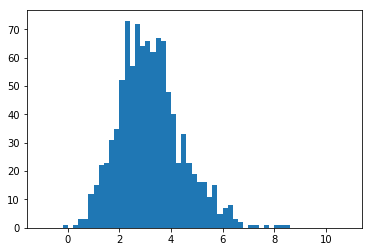

In [6]:
weights = np.array([m.w.numpy() for m in ms]).reshape(-1)
plt.hist(weights, bins=np.arange(-1,11,0.2))
plt.label
print("Mean = {}".format(np.mean(weights)))
print("STD = {}".format(np.std(weights)))

In [7]:
m = MNLogit()
m.data(np.concatenate(Xs,axis=0), np.concatenate(ys,axis=0), sws=np.concatenate(sws,axis=0))
m.fit(max_num_iter=100000, clip=1.0, clip_norm_ord=2)

In [8]:
m.w.numpy()

array([1.85061622])

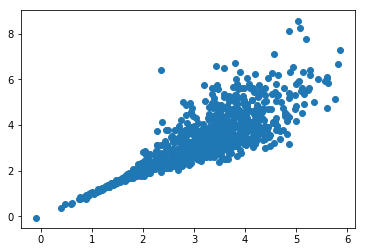

In [9]:
plt.scatter(w0, weights)

## Part 2 - Cross-fitting datasets with simple model vs hierarchical model. ##
### Run across many datasets generated with different $\mu$ and $\sigma$ ###

In this part, we generate 48 datasets where the weight $\theta \sim \mathcal{N}(\mu,\sigma)$, where $\mu = \{1,1.25,1.5,...,4.75\}$ and $\sigma \in \{0,1,2\}$. As with the example above, there are 1000 nodes, 20000 starting edges, and 120000 grown edges. (Only grown edges are counted in each dataset.)

For each dataset, we fit the simple model and the non-pooling hierarchical model and plot the weights for each model

In [10]:
def generate_data(params):
  mu, sigma = params
  num_nodes = 1000
  num_start_edges = 20000
  num_new_edges = 120000

  G = UndirectedMultiGraph(num_nodes)
  G.grow_erdos_renyi(num_start_edges)
  Xs, ys, sws = [list() for _ in range(num_nodes)], [list() for _ in range(num_nodes)], [list() for _ in range(num_nodes)]

  w0 = mu + sigma * np.random.randn(num_nodes)
  w1 = 0 + 0 * np.random.randn(num_nodes)
  w2 = 0 + 0 * np.random.randn(num_nodes)

  for i in range(num_new_edges):
    if i % 1000 == 0:
      sys.stdout.write('\r{} / {} edges added'.format(i, num_new_edges))
    info = G.grow_with_utility({'w0':w0,'w1':w1,'w2':w2}, num_negative=num_nodes-2, stratify=False, heterogeneous=True)
    X, y, actor = info['X'], info['y'], info['actor']
    Xs[actor].append(X)
    ys[actor].append(y)
    sws[actor].append(np.ones(num_nodes-1))
    

  Xs = [np.array(X)[:,:,0:1] for X in Xs]# N x C x 1 (only degree)
  ys = [np.array(y) for y in ys] # N
  sws = [np.array(sw) for sw in sws]
  return Xs, ys, sws, w0

def fit_data(Xs, ys, sws):  
  num_nodes = 1000
  ms = [MNLogit() for _ in range(num_nodes)]
  for i in range(num_nodes):
    sys.stdout.write("\rFitting on node {}".format(i))
    ms[i].data(Xs[i], ys[i], sws=sws[i])
    ms[i].fit(max_num_iter=100, clip=1.0, clip_norm_ord=2)
    
  weights = np.array([m.w.numpy() for m in ms]).reshape(-1)
  
  m = MNLogit()
  m.data(np.concatenate(Xs,axis=0), np.concatenate(ys,axis=0), sws=np.concatenate(sws,axis=0))
  m.fit(max_num_iter=100000, clip=1.0, clip_norm_ord=2)
  
  return m.w.numpy()[0], weights

In [11]:
mus = np.hstack([np.arange(1,5,.25)] * 3)
sigmas = [0] * 16 + [1] * 16 + [2] * 16
with Pool(48) as p:
  data = p.map(generate_data, list(zip(mus, sigmas)))

In [12]:
true_weights = []
results = []
for Xs, ys, sws, ws in data:
  true_weights.append(ws)
  results.append(fit_data(Xs, ys, sws))

Fitting on node 999

In [37]:
with open('homo-hetero','w') as f:
  f.write("{},{},result-homo\n".format(','.join(['true-{}'.format(i) for i in range(1000)]),\
                                       ','.join(['result-hetero-{}'.format(i) for i in range(1000)])))
  for i in range(48):
    f.write("{},{},{}\n".format(','.join(map(str,list(true_weights[i]))),\
                                ','.join(map(str,list(results[i][1]))),\
                                results[i][0]))

# Load saved result

In [38]:
df = pd.read_csv("homo-hetero")
df

,true-0,true-1,true-2,true-3,true-4,true-5,true-6,true-7,true-8,true-9,...,result-hetero-991,result-hetero-992,result-hetero-993,result-hetero-994,result-hetero-995,result-hetero-996,result-hetero-997,result-hetero-998,result-hetero-999,result-homo
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.135628,0.827504,0.137301,2.380331,0.550582,0.254584,0.712708,2.086710,2.148286,0.989970
1,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,...,-0.062946,1.111371,0.537933,2.888165,0.785887,0.389454,0.963008,2.243068,2.075106,1.237612
2,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,...,0.158582,1.459958,1.460322,3.284310,1.057795,0.614448,1.565256,2.058265,2.101796,1.488062
3,1.750000,1.750000,1.750000,1.750000,1.750000,1.750000,1.750000,1.750000,1.750000,1.750000,...,0.505862,1.790041,2.031079,3.233812,1.236978,0.838945,1.753881,1.763731,2.355295,1.733310
4,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,0.764035,1.799206,2.223477,3.131106,1.854441,1.085297,2.126812,2.122324,2.384347,1.987608
5,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,...,1.281920,2.293660,2.613084,2.513599,2.297138,1.933177,2.394772,2.000556,2.767247,2.253468
6,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,...,2.509124,2.304373,2.584990,2.597073,2.523818,2.369390,2.389562,2.389790,2.334867,2.495345
7,2.750000,2.750000,2.750000,2.750000,2.750000,2.750000,2.750000,2.750000,2.750000,2.750000,...,3.028131,2.369628,2.754432,3.183115,2.768247,3.228061,3.362284,2.845235,2.635026,2.737180
8,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.880768,2.889391,3.502322,2.894585,2.984734,2.995532,3.838455,3.182133,2.973641,2.982500
9,3.250000,3.250000,3.250000,3.250000,3.250000,3.250000,3.250000,3.250000,3.250000,3.250000,...,3.379660,3.319532,4.037315,3.146670,2.620188,2.607623,2.849429,3.765878,3.319274,3.224620


In [39]:
hom = df['result-homo'].values.reshape(3,16)
het = df[['result-hetero-{}'.format(i) for i in range(1000)]].values.reshape(3,16,1000)

In [40]:
het_p25 = np.percentile(het, q=25, axis=2)
het_p50 = np.percentile(het, q=50, axis=2)
het_p75 = np.percentile(het, q=75, axis=2)
het_mid = (het_p75 + het_p25) / 2
het_bar = (het_p75 - het_p25) / 2

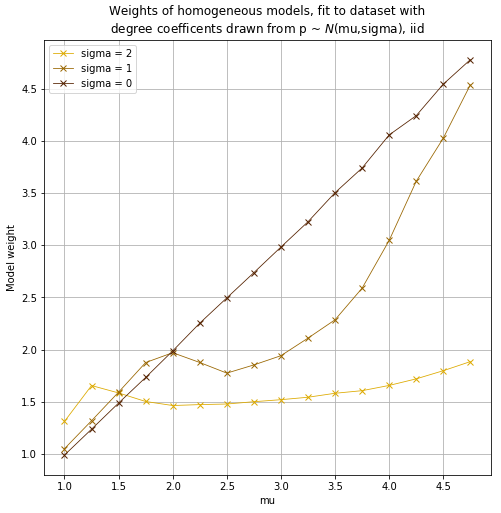

In [41]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(1,5,0.25), hom[2], 'x-', color='#DDAA00', linewidth=.8, label='sigma = 2')
plt.plot(np.arange(1,5,0.25), hom[1], 'x-', color='#996600', linewidth=.8, label='sigma = 1')
plt.plot(np.arange(1,5,0.25), hom[0], 'x-', color='#552200', linewidth=.8, label='sigma = 0')

plt.xlabel("mu")
plt.ylabel("Model weight")
plt.title("Weights of homogeneous models, fit to dataset with\ndegree coefficents drawn from p ~ $N$(mu,sigma), iid")
plt.grid()
plt.legend()

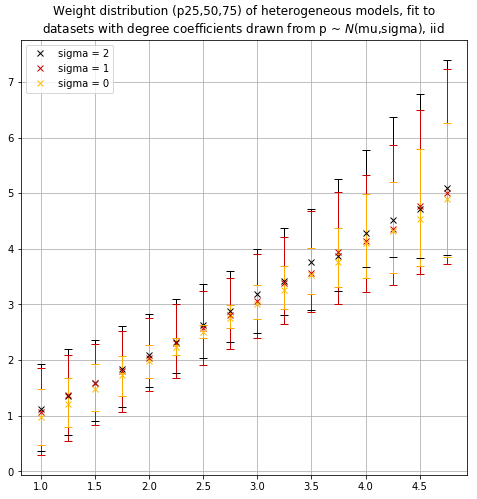

In [42]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(1,5,0.25), het_p50[2], 'x', color='#000000', linewidth=2.0, label='sigma = 2')
plt.errorbar(np.arange(1,5,0.25), y=het_mid[2], yerr=het_bar[1], color='#000000', linewidth=1.0, ls='none', capsize=4)

plt.plot(np.arange(1,5,0.25), het_p50[1], 'x', color='#CC0000', linewidth=2.0, label='sigma = 1')
plt.errorbar(np.arange(1,5,0.25), y=het_mid[1], yerr=het_bar[1], color='#CC0000', linewidth=1.0, ls='none', capsize=4)

plt.plot(np.arange(1,5,0.25), het_p50[0], 'x', color='#FFBB00', linewidth=2.0, label='sigma = 0')
plt.errorbar(np.arange(1,5,0.25), y=het_mid[0], yerr=het_bar[0], color='#FFAA00', linewidth=1.0, ls='none', capsize=4)
plt.title("Weight distribution (p25,50,75) of heterogeneous models, fit to\ndatasets with degree coefficients drawn from p ~ $N$(mu,sigma), iid")
plt.grid()
plt.legend()

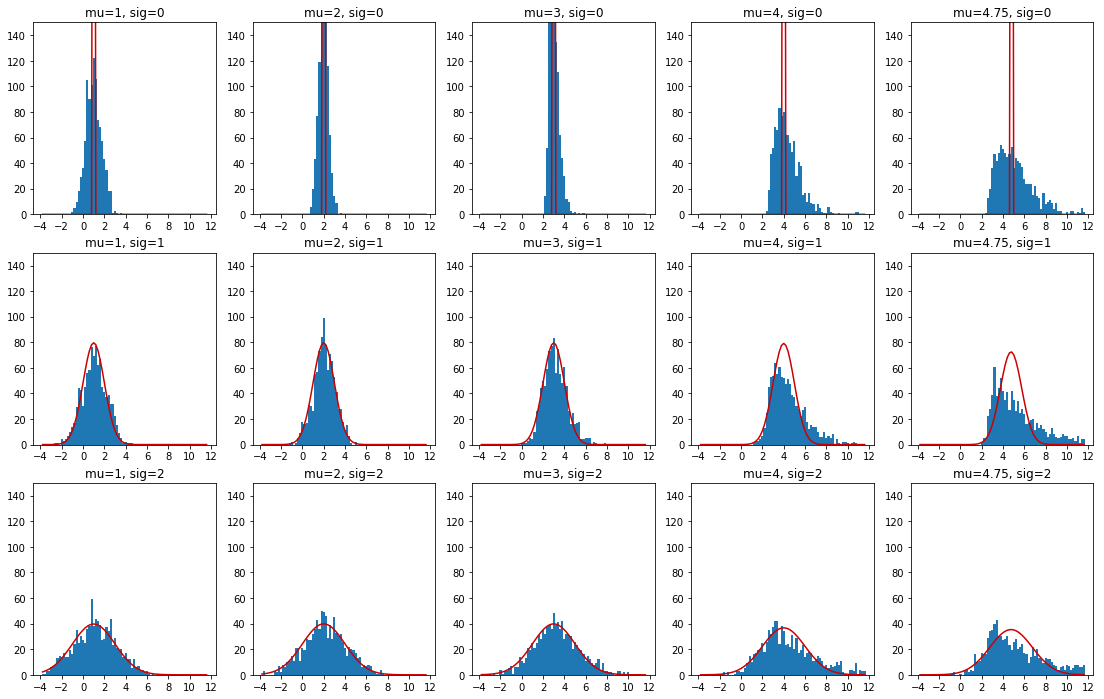

In [43]:
from scipy.stats import norm
plt.figure(figsize=(19,12))

def plot_dists(row, col):
  mu = col+1 if col < 4 else 4.75
  sigma = row
  bins = np.arange(-3.9,11.9,0.2)

  count, _, _ = plt.hist(het[sigma][int(4*(mu-1))], bins=bins)
  norm_dist = norm.cdf((bins[1:]-mu) / (sigma+0.001)) - norm.cdf((bins[:-1]-mu)/(sigma+0.001))
  plt.ylim(0,150)
  plt.plot((bins[1:]+bins[:-1])/2, norm_dist * np.sum(count), color='#CC0000')
  plt.xticks([-4.0,-2.0,0.0,2.0,4.0,6.0,8.0,10.0,12.0])
for i in range(15):
  plt.subplot(3,5,i+1)
  plot_dists(i//5, i%5)

  plt.title("mu={}, sig={}".format(i%5+1  if i%5 < 4 else 4.75, i//5))

In [44]:
means = np.mean(het, axis=2)
stds = np.std(het, axis=2)
out = np.core.defchararray.add(np.around(means,decimals=3).astype(str), np.core.defchararray.add(' (', np.core.defchararray.add(np.around(stds,decimals=3).astype(str), ')')))
pd.DataFrame(out).rename(index=str, columns={i:str(1+i/4) for i in range(16)})

,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75
0,1.0 (0.728),1.246 (0.664),1.492 (0.595),1.734 (0.517),1.982 (0.447),2.235 (0.248),2.518 (0.179),2.799 (0.315),3.078 (0.474),3.336 (0.57),3.645 (0.655),3.922 (0.879),4.348 (1.209),4.765 (4.176),5.206 (3.705),5.744 (4.481)
1,1.061 (1.16),1.319 (1.132),1.57 (1.109),1.798 (1.064),2.067 (1.012),2.345 (1.006),2.593 (1.003),2.865 (1.029),3.179 (1.127),3.484 (1.186),3.822 (1.379),4.14 (1.482),4.525 (2.11),5.134 (3.598),5.896 (5.596),6.888 (8.144)
2,1.139 (2.001),1.378 (1.985),1.634 (2.0),1.868 (1.972),2.179 (2.027),2.42 (2.02),2.702 (2.082),2.967 (2.095),3.295 (2.182),3.639 (2.287),3.988 (3.619),5.101 (6.642),5.956 (7.808),6.355 (8.109),6.477 (7.311),6.909 (7.491)


In [ ]:
plt.figure(figsize=(19,12))

def scatter_coeffs(row, col):
  mu = col+1 if col < 4 else 4.75
  sigma = row
  bins = np.arange(-3.9,11.9,0.2)

  #count, _, _ = plt.hist(het[sigma][int(4*(mu-1))], bins=bins)
  plt.scatter(het[])

  #plt.ylim(0,150)
  #plt.plot((bins[1:]+bins[:-1])/2, norm_dist * np.sum(count), color='#CC0000')
  #plt.xticks([-4.0,-2.0,0.0,2.0,4.0,6.0,8.0,10.0,12.0])
  
for i in range(15):
  plt.subplot(3,5,i+1)
  plot_dists(i//5, i%5)

  plt.title("mu={}, sig={}".format(i%5+1  if i%5 < 4 else 4.75, i//5))